## PART 1 - Forward Propagation 

In [124]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import copy
import math
import time

In [125]:
# Initialize W and b
def initialize_parameters(layer_dims):
    parameters = {}
    layers = len(layer_dims)
    for layer in range(1,layers):
        layer_input = layer_dims[layer-1]
        layer_output = layer_dims[layer]
        parameters['W' + str(layer)] = np.random.randn(layer_output, layer_input) / layer_output
        parameters['b' + str(layer)] = np.zeros((layer_output, 1))
    return parameters

In [126]:
# Compute Z = A_prev * W + b
def linear_forward(A, W, b):
    return np.dot(W, A) + b, {"A": A, "W": W, "b": b}

In [127]:
# Apply shifted softmax on Z
def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True), Z

In [128]:
# Apply ReLU on Z
def relu(Z):
    return np.maximum(0, Z), Z

In [129]:
# Compute A = activation_function(Z) = activation_function(A_prev * W + b)
def linear_activation_forward(A_prev, W, B, activation):
    Z, linear_cache = linear_forward(A_prev, W, B)
    if activation == "softmax":
        A, activation_cache = softmax(Z)
    elif activation == "relu":
        A, activation_cache = relu(Z)
    return A, {"linear_cache": linear_cache, "activation_cache": activation_cache}

In [130]:
# Apply L-1 times ReLU, and 1 time softmax.
# Apply batch normalization after ReLU if using it
def L_model_forward(X, parameters, use_batchnorm):
    caches = []
    batchnorm_caches = []
    L = len(parameters)//2
    for layer in range(1, L):
        X, cache = linear_activation_forward(X, parameters['W' + str(layer)], parameters['b' + str(layer)], activation="relu")
        caches.append(cache)
        if use_batchnorm:
            X, batchnorm_cache = apply_batchnorm(X)
            batchnorm_caches.append(batchnorm_cache)
    AL, cache = linear_activation_forward(X, parameters['W' + str(L)], parameters['b' + str(L)], activation="softmax")
    caches.append(cache)
    return AL, caches, batchnorm_caches

In [131]:
# Compute the categorical cross-entropy loss between the network output (AL) and the real output (Y)
# Apply L2 normalization if using it - add OMEGA to the categorical cross-entropy loss
def compute_cost(AL, Y):
    global eps
    cost = -np.mean(np.sum(Y*np.log(AL+eps), axis=0))
    global L2_normalization
    if L2_normalization:
        global weight_decay
        global parameters
        for l in range(1, len(parameters) // 2 + 1):
            cost += (weight_decay / 2) * sum(np.sum(np.square(w)) for w in parameters["W" + str(l)])
    return cost

In [132]:
# Apply batch normalization on A: A_norm = (A-mean(A))/std(A)
def apply_batchnorm(A):
    global eps
    mean = np.mean(A, axis=1, keepdims=True)
    var = np.var(A, axis=1, keepdims=True)
    return (A-mean)/np.sqrt(var+eps), {'A': A, 'mean': mean, 'var': var}

## PART 2 - Backward Propagation

In [133]:
# compute the gradients of A_prev, W and b (explained in the report)
# Apply L2 normalization if using it - add weight_decay * W to dW
def Linear_backward(dZ, cache):
    A_prev = cache['A']
    W = cache['W']
    m = A_prev.shape[1]
    dA_prev = np.dot(W.T, dZ)
    dW = np.dot(dZ, A_prev.T) / m
    global L2_normalization
    if L2_normalization:
        global weight_decay
        dW += weight_decay * W
    db = np.mean(dZ, axis=1, keepdims=True)
    return dA_prev, dW, db

In [134]:
# Compute the gradient through a layer.
# Compute the gradient of the batch normalization layer before the ReLU layer if using it
def linear_activation_backward(dA, cache, activation, batchnorm_cache=None):
    activation_cache = cache['activation_cache']
    linear_cache = cache['linear_cache']
    if use_batchnorm and activation == "relu":
        dBN = batchnorm_backward(dA, batchnorm_cache)
        dZ = relu_backward(dBN, activation_cache)
    elif activation == "relu":  
        dZ = relu_backward(dA, activation_cache)
    else:
        dZ = softmax_backward(dA, activation_cache)
    return Linear_backward(dZ, linear_cache)

In [135]:
# Compute the gradient through the batch normalization layer
def batchnorm_backward(dA, batchnorm_cache):
    # A before normalization
    A = batchnorm_cache['A']
    # Mean of A
    mean = batchnorm_cache['mean']
    # Var of A
    var = batchnorm_cache['var']

    # The same epsilon used in the batch normalization step
    global eps

    # Variables for the next computations:
    D, N = A.shape
    AM = A-mean
    VE = var+eps
    DN = np.ones((D,N))/N

    # The following calculations took from: "https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html"
    # THIS IS THEORETICAL EXPLAINATION OF THE BACKPROPAGATION FLOW THROUGH THE BATCH NORMALIZATION LAYER.
    dA1 = (dA-(AM * DN * np.sum(dA*AM, axis=1)[:, np.newaxis])/VE)/np.sqrt(VE)
    dA2 = DN * (np.sum(dA1, axis=1)[:, np.newaxis])
    return dA1 - dA2

In [136]:
# Compute the gradient through ReLU layer
def relu_backward (dA, activation_cache):
    dZ = np.array(dA, copy=True)
    dZ[activation_cache <= 0] = 0
    return dZ

In [137]:
# Compute the gradient through Softmax layer
# It's returning only dA, instead of dA-Y because I don't have access to Y here,
# so before calling to this function I passed to this function AL-Y instead of just AL, so the dA here is already dA-Y.
def softmax_backward (dA, activation_cache):
    return dA

In [138]:
# Compute the gradient through the softmax layer, then through the ReLU layers.
# If using batch normalization then we pass the current batchnorm cache to the gradient computation of ReLU
def L_model_backward(AL, Y, caches, batchnorm_caches):
    grads = {}
    L = len(caches)
    global eps
    dAL = AL - Y
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, caches[-1], "softmax")
    for l in reversed(range(L-1)):
        if use_batchnorm:
            grads["dA" + str(l)], grads["dW" + str(l + 1)], grads["db" + str(l + 1)] = linear_activation_backward(grads["dA" + str(l + 1)], caches[l], "relu", batchnorm_caches[l])
        else:
            grads["dA" + str(l)], grads["dW" + str(l + 1)], grads["db" + str(l + 1)] = linear_activation_backward(grads["dA" + str(l + 1)], caches[l], "relu")
    return grads

In [139]:
# Update W and b according to their gradients and learning rate.
# If using L2 normalization then we have a little different in computation of the new parameters (according to the slides of lecture 2)
def Update_parameters(parameters, grads, learning_rate):
    for l in range(1, (len(parameters)//2)+1):
        global L2_normalization
        if L2_normalization:
            global weight_decay
            parameters["W" + str(l)] = (1 - learning_rate * weight_decay) * parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
            parameters["b" + str(l)] = (1 - learning_rate * weight_decay) * parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]
        else:
            parameters["W" + str(l)] -= learning_rate * grads["dW" + str(l)]
            parameters["b" + str(l)] -= learning_rate * grads["db" + str(l)]
    return parameters

## PART 3 - Training

In [140]:
# Split X and Y into batches of size batch_size
def split_into_batches(X, Y, batch_size):
    m = X.shape[0]
    batches = []

    # Randomly chooses a permutation of X. Then the same permutation is applied for Y.
    permutation = np.random.permutation(m)
    shuffled_X = X[permutation].T
    shuffled_Y = Y[permutation].T

    # Split X and Y to batches according to the batch_size and the permutation
    num_complete_minibatches = m // batch_size
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * batch_size: (k + 1) * batch_size]
        mini_batch_Y = shuffled_Y[:, k * batch_size: (k + 1) * batch_size]
        batch = (mini_batch_X, mini_batch_Y)
        batches.append(batch)

    # If there are remaining samples in X and Y then put them in the last batch which will be of size < batch_size
    if m % batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * batch_size: m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * batch_size: m]
        batch = (mini_batch_X, mini_batch_Y)
        batches.append(batch)

    return batches

In [141]:
# Split X and Y into mini-batches. For each mini-batch train the network by:
# compute the network output (forward)
# compute the cost
# Compute the gradients (backward)
# update the parameters of the network
# Every 100 batches, compute statistics and stopping criterion
def L_layer_model(X, Y, layers_dims, learning_rate, num_iterations, batch_size):
    global batches_counter
    global use_batchnorm
    global x_val
    global y_val
    global previous_accuracy
    global validation_accuracy
    global stop
    global parameters
    
    costs = []
    batches = split_into_batches(X, Y, batch_size)
    for batch in batches:
        X_mini_batch = batch[0]
        Y_mini_batch = batch[1]
        AL, caches, bathcnorm_caches = L_model_forward(X_mini_batch, parameters, use_batchnorm)
        cost = compute_cost(AL, Y_mini_batch)
        grads = L_model_backward(AL, Y_mini_batch, caches, bathcnorm_caches)
        parameters = Update_parameters(parameters, grads, learning_rate)
        batches_counter+=1
        if batches_counter == 100:
            batches_counter=0
            validation_accuracy = Predict(x_val, y_val, parameters)
            costs.append(cost)
            print(f"cost: {cost}")
            print(f"validation_accuracy: {validation_accuracy}")
            if validation_accuracy - previous_accuracy < stopping_criterion_threshold:
                print("STOP")
                stop = True
                break
            previous_accuracy = validation_accuracy
    return parameters, costs

In [142]:
# Compute the accuracy of X and Y according to the given parameters on the network
def Predict(X, Y, parameters):
    global use_batchnorm
    AL, _, _ = L_model_forward(X.T, parameters, use_batchnorm)
    softmax_AL, _ = softmax(AL) 
    return np.mean(np.argmax(softmax_AL, axis=0) == np.argmax(Y.T, axis=0))

## PART 4 - Classifying

In [143]:
#weight_decays = [0.01,0.001,0.0005,0.0001]
#batch_sizes = [250,500,1000]
weight_decays = [0.0005]
batch_sizes = [500,1000]
stopping_criterion_threshold = 1e-3
layers_dims = [784,20,7,5,10]
learning_rate=0.009
epochs = 100
eps = 1e-8

In [144]:
# Load the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Split the training data into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [145]:
# Change Y to one-hot-encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
y_val = to_categorical(y_val, 10)
# Flat X
x_train = x_train.reshape((x_train.shape[0], 28 * 28))
x_test = x_test.reshape((x_test.shape[0], 28 * 28))
x_val = x_val.reshape((x_val.shape[0], 28 * 28))

In [146]:
# Initialize start parameters for all of the following experiments
start_parameters = initialize_parameters(layers_dims)

In [147]:
# Zero the final accuracy variables for correctness in reruns
final_train_accuracy = 0
final_test_accuracy = 0
final_val_accuracy = 0

In [148]:
# Train the network without normalization
use_batchnorm = False
L2_normalization = False
best_batch_size = -1
start_time = time.time()
for batch_size in batch_sizes:
    num_iterations = int(math.ceil(48000/batch_size))
    batches_counter = 0
    stop = False
    parameters = copy.deepcopy(start_parameters)
    previous_accuracy = -1
    validation_accuracy = -1
    costs_list=[]
    for i in tqdm(range(epochs)):
        parameters, costs = L_layer_model(x_train, y_train, layers_dims, learning_rate, num_iterations, batch_size)
        costs_list += costs
        if stop:
            break
    # After finishing the training, check its accuracy
    train_accuracy = Predict(x_train, y_train, parameters)
    test_accuracy = Predict(x_test, y_test, parameters)
    val_accuracy = Predict(x_val, y_val, parameters)
    print(f"batch size: {batch_size}")
    print(f"train accuracy: {train_accuracy}")
    print(f"test accuracy: {test_accuracy}")
    print(f"val accuracy: {val_accuracy}")
    # Maintain the best accuracies and the best batch size among all the batch sizes
    if val_accuracy > final_val_accuracy:
        final_train_accuracy = train_accuracy
        final_test_accuracy = test_accuracy
        final_val_accuracy = val_accuracy
        best_batch_size = batch_size
end_time = time.time()
elapsed_time = end_time - start_time

  1%|▊                                                                                 | 1/100 [00:00<01:05,  1.51it/s]

cost: 1.3986621025105115
validation_accuracy: 0.4841666666666667


  2%|█▋                                                                                | 2/100 [00:01<01:10,  1.39it/s]

cost: 1.334535500931266
validation_accuracy: 0.5541666666666667


  3%|██▍                                                                               | 3/100 [00:02<01:13,  1.33it/s]

cost: 1.154458073273073
validation_accuracy: 0.62475


  4%|███▎                                                                              | 4/100 [00:03<01:15,  1.28it/s]

cost: 1.0275927977355408
validation_accuracy: 0.6708333333333333


  5%|████                                                                              | 5/100 [00:03<01:11,  1.32it/s]

cost: 1.0110274099926424
validation_accuracy: 0.7015833333333333


  6%|████▉                                                                             | 6/100 [00:04<01:11,  1.31it/s]

cost: 0.7397149442898928
validation_accuracy: 0.7234166666666667


  7%|█████▋                                                                            | 7/100 [00:05<01:11,  1.30it/s]

cost: 0.6239924360331499
validation_accuracy: 0.7965


  8%|██████▌                                                                           | 8/100 [00:05<01:07,  1.36it/s]

cost: 0.5771434701675098
validation_accuracy: 0.8144166666666667


  9%|███████▍                                                                          | 9/100 [00:06<01:05,  1.39it/s]

cost: 0.585999051018075
validation_accuracy: 0.8304166666666667


 10%|████████                                                                         | 10/100 [00:07<01:10,  1.28it/s]

cost: 0.39862008711602037
validation_accuracy: 0.8608333333333333


 11%|████████▉                                                                        | 11/100 [00:08<01:11,  1.24it/s]

cost: 0.5152216688077003
validation_accuracy: 0.8593333333333333
STOP


batch size: 500
train accuracy: 0.8641875
test accuracy: 0.8654
val accuracy: 0.8593333333333333


  2%|█▋                                                                                | 2/100 [00:01<01:08,  1.44it/s]

cost: 1.470176251545488
validation_accuracy: 0.47775


  4%|███▎                                                                              | 4/100 [00:02<01:08,  1.40it/s]

cost: 1.2734124031722591
validation_accuracy: 0.561


  6%|████▉                                                                             | 6/100 [00:04<01:06,  1.40it/s]

cost: 1.1124855626463772
validation_accuracy: 0.6341666666666667


  8%|██████▌                                                                           | 8/100 [00:05<01:01,  1.50it/s]

cost: 0.9927843539919083
validation_accuracy: 0.68


 10%|████████                                                                         | 10/100 [00:07<01:03,  1.42it/s]


cost: 1.0443566736718055
validation_accuracy: 0.6239166666666667
STOP
batch size: 1000
train accuracy: 0.6205
test accuracy: 0.6232
val accuracy: 0.6239166666666667


In [149]:
# Print results
print(elapsed_time)
print(best_batch_size)
print(final_train_accuracy)
print(final_test_accuracy)
print(final_val_accuracy)
final_train_accuracy = 0
final_test_accuracy = 0
final_val_accuracy = 0

16.456014394760132
500
0.8641875
0.8654
0.8593333333333333


Number of near-zeros: 8073
Mean: -0.00023410348405882974


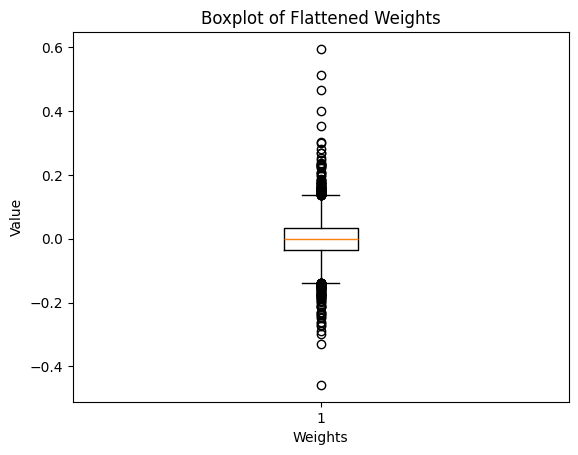

In [150]:
weights = [parameters[f"W{i}"] for i in range(1,5)]
flattened_weights = np.array([item for sublist in weights for item in sublist.flatten()])
count = np.count_nonzero(flattened_weights < 0.001)
print("Number of near-zeros:", count)
print(f"Mean: {np.mean(flattened_weights)}")
plt.boxplot(flattened_weights)
plt.xlabel("Weights")
plt.ylabel("Value")
plt.title("Boxplot of Flattened Weights")
plt.show()

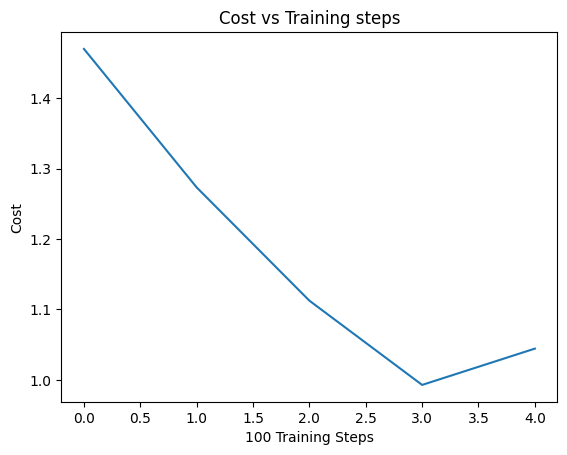

In [151]:
# Plot the cost graph
plt.plot(costs_list)
plt.title("Cost vs Training steps")
plt.xlabel('100 Training Steps')
plt.ylabel('Cost')
plt.show()

In [152]:
# Train the network using batch normalization
use_batchnorm = True
L2_normalization = False
best_batch_size = -1
start_time = time.time()
for batch_size in batch_sizes:
    num_iterations = int(math.ceil(48000/batch_size))
    batches_counter = 0
    stop = False
    parameters = copy.deepcopy(start_parameters)
    previous_accuracy = -1
    validation_accuracy = -1
    costs_list=[]
    for i in tqdm(range(epochs)):
        parameters, costs = L_layer_model(x_train, y_train, layers_dims, learning_rate, num_iterations, batch_size)
        costs_list += costs
        if stop:
            break
    # After finishing the training, check its accuracy
    train_accuracy = Predict(x_train, y_train, parameters)
    test_accuracy = Predict(x_test, y_test, parameters)
    val_accuracy = Predict(x_val, y_val, parameters)
    print(f"batch size: {batch_size}")
    print(f"train accuracy: {train_accuracy}")
    print(f"test accuracy: {test_accuracy}")
    print(f"val accuracy: {val_accuracy}")
    # Maintain the best accuracies and the best batch size among all the batch sizes
    if val_accuracy > final_val_accuracy:
        final_train_accuracy = train_accuracy
        final_test_accuracy = test_accuracy
        final_val_accuracy = val_accuracy
        best_batch_size = batch_size
end_time = time.time()
elapsed_time = end_time - start_time

  1%|▊                                                                                 | 1/100 [00:00<01:24,  1.18it/s]

cost: 2.147244858118366
validation_accuracy: 0.2920833333333333


  2%|█▋                                                                                | 2/100 [00:01<01:12,  1.35it/s]

cost: 1.973790781746719
validation_accuracy: 0.45775


  3%|██▍                                                                               | 3/100 [00:02<01:16,  1.27it/s]

cost: 1.7828724443542874
validation_accuracy: 0.5138333333333334


  4%|███▎                                                                              | 4/100 [00:03<01:21,  1.18it/s]

cost: 1.6592660879735555
validation_accuracy: 0.54825


  5%|████                                                                              | 5/100 [00:04<01:20,  1.18it/s]

cost: 1.525217822188876
validation_accuracy: 0.59475


  6%|████▉                                                                             | 6/100 [00:04<01:17,  1.22it/s]

cost: 1.4416028912884176
validation_accuracy: 0.62625


  7%|█████▋                                                                            | 7/100 [00:05<01:18,  1.18it/s]

cost: 1.3440748475822517
validation_accuracy: 0.64875


  8%|██████▌                                                                           | 8/100 [00:06<01:21,  1.13it/s]

cost: 1.24148921453852
validation_accuracy: 0.6683333333333333


  9%|███████▍                                                                          | 9/100 [00:07<01:19,  1.15it/s]

cost: 1.1689075240506672
validation_accuracy: 0.6775


 10%|████████                                                                         | 10/100 [00:08<01:22,  1.09it/s]

cost: 1.1642793728012126
validation_accuracy: 0.6865833333333333


 11%|████████▉                                                                        | 11/100 [00:09<01:22,  1.07it/s]

cost: 1.075073858469777
validation_accuracy: 0.6970833333333334


 12%|█████████▋                                                                       | 12/100 [00:10<01:25,  1.03it/s]

cost: 1.0581590401946763
validation_accuracy: 0.7059166666666666


 13%|██████████▌                                                                      | 13/100 [00:11<01:20,  1.07it/s]

cost: 1.0254974248847393
validation_accuracy: 0.7164166666666667


 14%|███████████▎                                                                     | 14/100 [00:12<01:13,  1.16it/s]

cost: 0.9197828169897659
validation_accuracy: 0.7283333333333334


 15%|████████████▏                                                                    | 15/100 [00:12<01:09,  1.23it/s]

cost: 1.017159977788037
validation_accuracy: 0.73925


 16%|████████████▉                                                                    | 16/100 [00:13<01:10,  1.18it/s]

cost: 0.8914402187104115
validation_accuracy: 0.7545833333333334


 17%|█████████████▊                                                                   | 17/100 [00:14<01:08,  1.20it/s]

cost: 0.8998700804634163
validation_accuracy: 0.773


 19%|███████████████▍                                                                 | 19/100 [00:16<01:06,  1.22it/s]

cost: 0.8691068534423021
validation_accuracy: 0.7849166666666667


 20%|████████████████▏                                                                | 20/100 [00:17<01:08,  1.16it/s]

cost: 0.8276646320251115
validation_accuracy: 0.8020833333333334


 21%|█████████████████                                                                | 21/100 [00:18<01:06,  1.19it/s]

cost: 0.7827248125700594
validation_accuracy: 0.8141666666666667


 22%|█████████████████▊                                                               | 22/100 [00:18<01:05,  1.19it/s]

cost: 0.7428639157539706
validation_accuracy: 0.8240833333333333


 23%|██████████████████▋                                                              | 23/100 [00:19<01:05,  1.18it/s]

cost: 0.7398638619360725
validation_accuracy: 0.8354166666666667


 24%|███████████████████▍                                                             | 24/100 [00:20<01:07,  1.12it/s]

cost: 0.730496599669079
validation_accuracy: 0.8444166666666667


 25%|████████████████████▎                                                            | 25/100 [00:21<01:05,  1.14it/s]

cost: 0.6542230072693865
validation_accuracy: 0.8501666666666666


 26%|█████████████████████                                                            | 26/100 [00:22<01:02,  1.18it/s]

cost: 0.6698375163509239
validation_accuracy: 0.8576666666666667


 27%|█████████████████████▊                                                           | 27/100 [00:23<01:01,  1.18it/s]

cost: 0.6808960396593002
validation_accuracy: 0.8619166666666667


 28%|██████████████████████▋                                                          | 28/100 [00:23<01:00,  1.19it/s]

cost: 0.6270797702313169
validation_accuracy: 0.8685833333333334


 29%|███████████████████████▍                                                         | 29/100 [00:24<00:57,  1.25it/s]

cost: 0.6211726469665121
validation_accuracy: 0.8725


 30%|████████████████████████▎                                                        | 30/100 [00:25<00:59,  1.17it/s]

cost: 0.5922489546311132
validation_accuracy: 0.8783333333333333


 31%|█████████████████████████                                                        | 31/100 [00:26<01:01,  1.12it/s]

cost: 0.5624337462030012
validation_accuracy: 0.8799166666666667


 32%|█████████████████████████▉                                                       | 32/100 [00:27<01:01,  1.11it/s]

cost: 0.6439147034617447
validation_accuracy: 0.8843333333333333


 33%|██████████████████████████▋                                                      | 33/100 [00:28<01:01,  1.10it/s]

cost: 0.5749271494144326
validation_accuracy: 0.8881666666666667


 34%|███████████████████████████▌                                                     | 34/100 [00:29<00:59,  1.10it/s]

cost: 0.5030996062973163
validation_accuracy: 0.88975


 35%|████████████████████████████▎                                                    | 35/100 [00:30<01:00,  1.08it/s]

cost: 0.5086872808311091
validation_accuracy: 0.8925833333333333


 36%|█████████████████████████████▏                                                   | 36/100 [00:31<01:01,  1.04it/s]

cost: 0.5149823708652802
validation_accuracy: 0.8944166666666666


 37%|█████████████████████████████▉                                                   | 37/100 [00:32<00:57,  1.09it/s]

cost: 0.4694698769675945
validation_accuracy: 0.8970833333333333


 38%|██████████████████████████████▊                                                  | 38/100 [00:33<00:54,  1.13it/s]

cost: 0.5388022846416928
validation_accuracy: 0.8980833333333333


 39%|███████████████████████████████▌                                                 | 39/100 [00:33<00:54,  1.13it/s]

cost: 0.4792038033306863
validation_accuracy: 0.8995


 40%|████████████████████████████████▍                                                | 40/100 [00:34<00:54,  1.11it/s]

cost: 0.49285204136751587
validation_accuracy: 0.90125


 41%|█████████████████████████████████▏                                               | 41/100 [00:35<00:53,  1.10it/s]

cost: 0.4762880731586946
validation_accuracy: 0.9030833333333333


 42%|██████████████████████████████████                                               | 42/100 [00:37<00:51,  1.13it/s]

cost: 0.45435212180820145
validation_accuracy: 0.9034166666666666
STOP


batch size: 500
train accuracy: 0.9136875
test accuracy: 0.9076
val accuracy: 0.9034166666666666


  2%|█▋                                                                                | 2/100 [00:01<01:21,  1.21it/s]

cost: 2.1529791985872615
validation_accuracy: 0.29691666666666666


  4%|███▎                                                                              | 4/100 [00:03<01:13,  1.30it/s]

cost: 1.9547914281316003
validation_accuracy: 0.46


  6%|████▉                                                                             | 6/100 [00:04<01:10,  1.34it/s]

cost: 1.8024431917437187
validation_accuracy: 0.5165833333333333


  8%|██████▌                                                                           | 8/100 [00:06<01:06,  1.39it/s]

cost: 1.6283859717769202
validation_accuracy: 0.5536666666666666


 10%|████████                                                                         | 10/100 [00:07<01:03,  1.41it/s]

cost: 1.517819847389315
validation_accuracy: 0.5974166666666667


 12%|█████████▋                                                                       | 12/100 [00:08<01:03,  1.38it/s]

cost: 1.4139350344121295
validation_accuracy: 0.62925


 14%|███████████▎                                                                     | 14/100 [00:10<01:03,  1.36it/s]

cost: 1.3282491435118426
validation_accuracy: 0.6514166666666666


 16%|████████████▉                                                                    | 16/100 [00:11<01:01,  1.38it/s]

cost: 1.2459730647216312
validation_accuracy: 0.6693333333333333


 19%|███████████████▍                                                                 | 19/100 [00:13<00:56,  1.42it/s]

cost: 1.2042485810186154
validation_accuracy: 0.6830833333333334


 21%|█████████████████                                                                | 21/100 [00:15<00:58,  1.36it/s]

cost: 1.1334203204366076
validation_accuracy: 0.6915833333333333


 23%|██████████████████▋                                                              | 23/100 [00:16<00:55,  1.39it/s]

cost: 1.0767283099552156
validation_accuracy: 0.7006666666666667


 25%|████████████████████▎                                                            | 25/100 [00:18<00:50,  1.48it/s]

cost: 1.0515205646714252
validation_accuracy: 0.7095833333333333


 27%|█████████████████████▊                                                           | 27/100 [00:19<00:55,  1.31it/s]

cost: 0.9913153859980346
validation_accuracy: 0.7205


 29%|███████████████████████▍                                                         | 29/100 [00:21<00:56,  1.26it/s]

cost: 0.9592112294042342
validation_accuracy: 0.7329166666666667


 31%|█████████████████████████                                                        | 31/100 [00:22<00:53,  1.30it/s]

cost: 0.9122288527900776
validation_accuracy: 0.7463333333333333


 33%|██████████████████████████▋                                                      | 33/100 [00:24<00:50,  1.33it/s]

cost: 0.8969386432479943
validation_accuracy: 0.7568333333333334


 35%|████████████████████████████▎                                                    | 35/100 [00:26<00:50,  1.29it/s]

cost: 0.8735402547615069
validation_accuracy: 0.7753333333333333


 37%|█████████████████████████████▉                                                   | 37/100 [00:27<00:50,  1.25it/s]

cost: 0.8500410494176915
validation_accuracy: 0.7879166666666667


 39%|███████████████████████████████▌                                                 | 39/100 [00:29<00:46,  1.30it/s]

cost: 0.8189583785802637
validation_accuracy: 0.8039166666666666


 41%|█████████████████████████████████▏                                               | 41/100 [00:30<00:44,  1.33it/s]

cost: 0.7858536409984933
validation_accuracy: 0.8185


 44%|███████████████████████████████████▋                                             | 44/100 [00:32<00:41,  1.34it/s]

cost: 0.7642649296305111
validation_accuracy: 0.82725


 46%|█████████████████████████████████████▎                                           | 46/100 [00:34<00:41,  1.29it/s]

cost: 0.7456429169445491
validation_accuracy: 0.8383333333333334


 48%|██████████████████████████████████████▉                                          | 48/100 [00:36<00:41,  1.25it/s]

cost: 0.7354881974441303
validation_accuracy: 0.8481666666666666


 50%|████████████████████████████████████████▌                                        | 50/100 [00:37<00:39,  1.26it/s]

cost: 0.6787010022093779
validation_accuracy: 0.8553333333333333


 52%|██████████████████████████████████████████                                       | 52/100 [00:39<00:38,  1.24it/s]

cost: 0.6403849946905054
validation_accuracy: 0.8613333333333333


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:40<00:35,  1.31it/s]

cost: 0.6475084561069356
validation_accuracy: 0.8673333333333333


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:42<00:33,  1.30it/s]

cost: 0.6080166393531936
validation_accuracy: 0.8711666666666666


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:43<00:33,  1.25it/s]

cost: 0.5957651510863398
validation_accuracy: 0.87625


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:45<00:31,  1.27it/s]

cost: 0.5703511320558354
validation_accuracy: 0.8811666666666667


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:47<00:29,  1.31it/s]

cost: 0.5499026324990112
validation_accuracy: 0.8820833333333333
STOP


batch size: 1000
train accuracy: 0.889875
test accuracy: 0.8859
val accuracy: 0.8820833333333333


In [153]:
# Print results
print(elapsed_time)
print(best_batch_size)
print(final_train_accuracy)
print(final_test_accuracy)
print(final_val_accuracy)
final_train_accuracy = 0
final_test_accuracy = 0
final_val_accuracy = 0

85.23216772079468
500
0.9136875
0.9076
0.9034166666666666


Number of near-zeros: 7991
Mean: -0.0002935434835711064


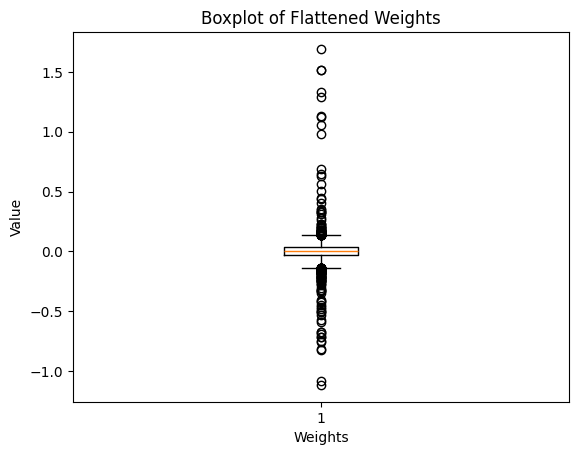

In [154]:
weights = [parameters[f"W{i}"] for i in range(1,5)]
flattened_weights = np.array([item for sublist in weights for item in sublist.flatten()])
count = np.count_nonzero(flattened_weights < 0.001)
print("Number of near-zeros:", count)
print(f"Mean: {np.mean(flattened_weights)}")
plt.boxplot(flattened_weights)
plt.xlabel("Weights")
plt.ylabel("Value")
plt.title("Boxplot of Flattened Weights")
plt.show()

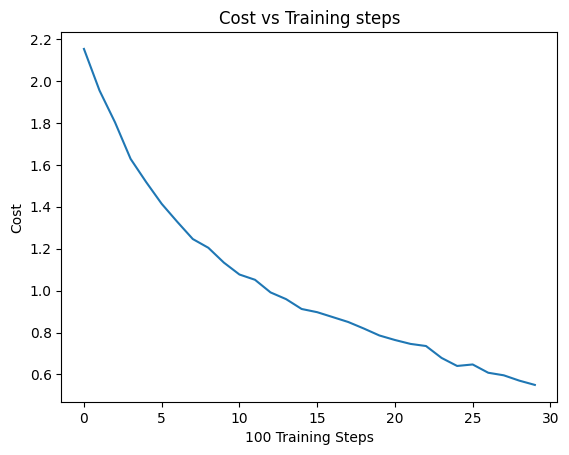

In [155]:
# Plot the cost graph
plt.plot(costs_list)
plt.title("Cost vs Training steps")
plt.xlabel('100 Training Steps')
plt.ylabel('Cost')
plt.show()

In [156]:
# Train the network using L2 normalization
use_batchnorm = False
L2_normalization = True
best_batch_size = -1
best_weight_decay = -1
start_time = time.time()
for weight_decay in weight_decays:
    for batch_size in batch_sizes:
        num_iterations = int(math.ceil(48000/batch_size))
        parameters = copy.deepcopy(start_parameters)
        batches_counter = 0
        stop = False
        previous_accuracy = -1
        validation_accuracy = -1
        costs_list=[]
        for i in tqdm(range(epochs)):
            parameters, costs = L_layer_model(x_train, y_train, layers_dims, learning_rate, num_iterations, batch_size)
            costs_list += costs
            if stop:
                break
        # After finishing the training, check its accuracy
        train_accuracy = Predict(x_train, y_train, parameters)
        test_accuracy = Predict(x_test, y_test, parameters)
        val_accuracy = Predict(x_val, y_val, parameters)
        print(f"weight decay: {weight_decay}")
        print(f"batch size: {batch_size}")
        print(f"train accuracy: {train_accuracy}")
        print(f"test accuracy: {test_accuracy}")
        print(f"val accuracy: {val_accuracy}")
        # Maintain the best accuracies, the best batch size, the best weight decay among all the batch sizes and weight decays
        if val_accuracy > final_val_accuracy:
            final_train_accuracy = train_accuracy
            final_test_accuracy = test_accuracy
            final_val_accuracy = val_accuracy
            best_batch_size = batch_size
            best_weight_decay = weight_decay
end_time = time.time()
elapsed_time = end_time - start_time

  1%|▊                                                                                 | 1/100 [00:00<01:10,  1.40it/s]

cost: 1.4632222648394486
validation_accuracy: 0.47725


  2%|█▋                                                                                | 2/100 [00:01<01:13,  1.33it/s]

cost: 1.3534503345142337
validation_accuracy: 0.5578333333333333


  3%|██▍                                                                               | 3/100 [00:02<01:10,  1.37it/s]

cost: 1.1714581118030425
validation_accuracy: 0.64025


  4%|███▎                                                                              | 4/100 [00:02<01:12,  1.32it/s]

cost: 1.0266690028322327
validation_accuracy: 0.67225


  5%|████                                                                              | 5/100 [00:03<01:14,  1.27it/s]

cost: 1.0263204733603664
validation_accuracy: 0.7075833333333333


  6%|████▉                                                                             | 6/100 [00:04<01:20,  1.17it/s]

cost: 0.7228390914581418
validation_accuracy: 0.7835


  7%|█████▋                                                                            | 7/100 [00:05<01:15,  1.23it/s]

cost: 0.7275634871611466
validation_accuracy: 0.7645833333333333
STOP


weight decay: 0.0005
batch size: 500
train accuracy: 0.7722291666666666
test accuracy: 0.7701
val accuracy: 0.7645833333333333


  2%|█▋                                                                                | 2/100 [00:01<01:08,  1.43it/s]

cost: 1.509003493512772
validation_accuracy: 0.4681666666666667


  4%|███▎                                                                              | 4/100 [00:02<01:09,  1.38it/s]

cost: 1.2936210202361238
validation_accuracy: 0.5558333333333333


  6%|████▉                                                                             | 6/100 [00:04<01:09,  1.35it/s]

cost: 1.236669617441305
validation_accuracy: 0.6034166666666667


  8%|██████▌                                                                           | 8/100 [00:06<01:12,  1.27it/s]

cost: 1.0022911998807025
validation_accuracy: 0.6836666666666666


 10%|████████                                                                         | 10/100 [00:07<01:10,  1.27it/s]

cost: 0.970156969154956
validation_accuracy: 0.6580833333333334
STOP


weight decay: 0.0005
batch size: 1000
train accuracy: 0.6569791666666667
test accuracy: 0.6584
val accuracy: 0.6580833333333334


In [157]:
# Print results
print(elapsed_time)
print(best_batch_size)
print(best_weight_decay)
print(final_train_accuracy)
print(final_test_accuracy)
print(final_val_accuracy)
final_train_accuracy = 0
final_test_accuracy = 0
final_val_accuracy = 0

14.247636079788208
500
0.0005
0.7722291666666666
0.7701
0.7645833333333333


Number of near-zeros: 8075
Mean: -0.00025456952918168643


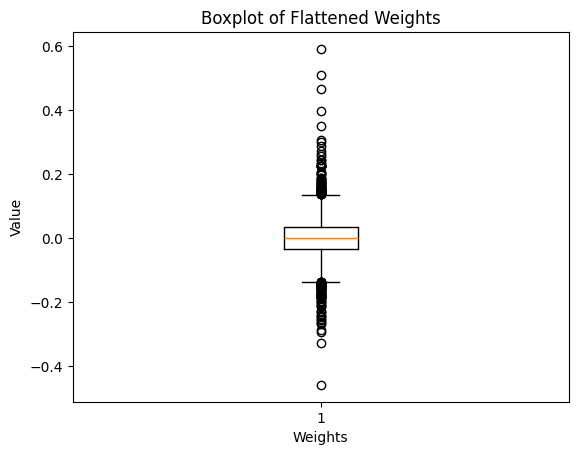

In [158]:
weights = [parameters[f"W{i}"] for i in range(1,5)]
flattened_weights = np.array([item for sublist in weights for item in sublist.flatten()])
count = np.count_nonzero(flattened_weights < 0.001)
print("Number of near-zeros:", count)
print(f"Mean: {np.mean(flattened_weights)}")
plt.boxplot(flattened_weights)
plt.xlabel("Weights")
plt.ylabel("Value")
plt.title("Boxplot of Flattened Weights")
plt.show()

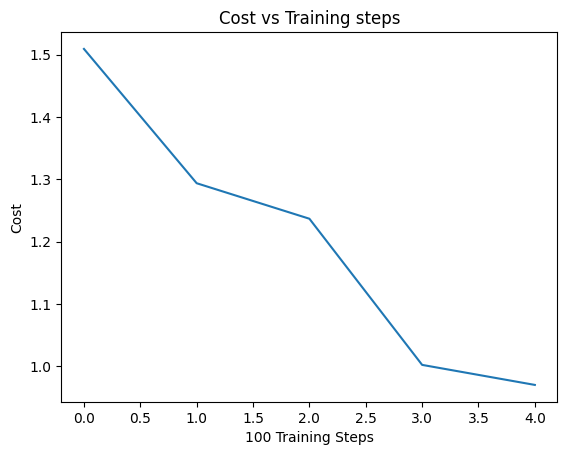

In [159]:
# Plot the cost graph
plt.plot(costs_list)
plt.title("Cost vs Training steps")
plt.xlabel('100 Training Steps')
plt.ylabel('Cost')
plt.show()